In [ ]:
# We will need to do a lot of plotting to explain various concepts.
Pkg.add("Gadfly")
using Gadfly

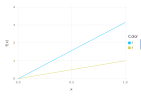

In [2]:
# A simple linear function we want to learn.
f(x) = π*x

plot([f, x -> x], 0, 1)

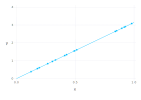

In [3]:
# It is incredibly rare that we know the function we want to learn, instead we usually have samples from it.
xys = [(x, f(x)) for x in rand(17)]

plot(
    layer(f, 0, 1),
    layer(x=[x for (x, _) in xys], y=[y for (_, y) in xys], Geom.point)
)

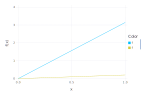

In [6]:
# A simple model to start with.
mutable struct LinearModel
    # Weight(s)
    w::Float64
end
# Initialisation doesn't have to be random, but it makes the step to neural models more natural.
LinearModel() = LinearModel(randn())
m             = LinearModel()
predict(m, x) = m.w*x

# Let's see what our randomly initialised model predicts!
plot([f, x -> predict(m, x)], 0, 1)

In [7]:
# Objective (or loss), how "good" is our current model given the data?

# Mean Square Objective, note the "magic" divide by two.
objective(m, x, y) = (y - predict(m, x))^2/2
objective(m, xys)  = mean(objective(m, x, y) for (x, y) in xys)

# So, how "good" is our current random model?
objective(m, xys)

1.6120817968152683

In [8]:
# Objective (or loss), how "good" is our current model given the data?

# Mean Square Objective, note the "magic" divide by two.
objective(m, x, y) = (y - predict(m, x))^2/2
objective(m, xys)  = mean(objective(m, x, y) for (x, y) in xys)

# So, how "good" is our current random model?
objective(m, xys)

1.6120817968152683

To improve our model, we can change our weights $w$ by taking the gradient of the objective function with respect to $w$.  Don't worry, this is still high school maths!

Let's first re-write the loss to make things easier, we use $y\prime$ as a shorthand for a prediction.

1. `objective(m, x, y) = (y - predict(m, x))^2/2`
2. $(y - y\prime)^2/2$
3. $(y - wx)^2/2$
4. $(y - wx)(y - wx)/2$
5. $(y^2 - 2ywx + (wx)^2)/2$

Now, let's calculate the gradient with respect to $w$.

1. $(-2yx + 2wx^2)/2$
2. $(-yx + wx^2)$
3. $wx^2 - yx$
4. $x(wx - y)$

In [9]:
# Our gradient, but now in code.
∇objective(m, x, y) = x*(m.w*x - y)
∇objective(m, xys)  = mean(∇objective(m, x, y) for (x, y) in xys)
    
∇objective(m, xys)

-1.0976670447352594

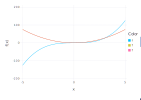

In [10]:
# It is easy to mess up gradients, so standard practice is to verify them.

# https://en.wikipedia.org/wiki/Finite_difference
finitediff(f, x; ϵ=10.0^-8.0) = (f(x + ϵ) - f(x - ϵ))/(2ϵ)
# In practice use Calculus.jl's `check_gradient` instead!

g(x)  = x^3
g′(x) = 3x^2

plot([g, g′, x -> finitediff(g, x)], -5, 5)

In [11]:
# Trusting plots can be a bit flaky, so let's calculate an error as well. 
mean((g′(x) - finitediff(g, x))^2 for x in linspace(-5, 5, 1024))

8.763533108456374e-14

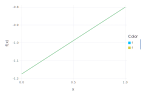

In [12]:
# Now, let's verify our gradient.
plot([w -> ∇objective(LinearModel(w), xys), w -> finitediff(v -> objective(LinearModel(v), xys), w)], 0, 1)

In [13]:
mean((∇objective(LinearModel(w), xys) - finitediff(v -> objective(LinearModel(v), xys), w))^2 for w in linspace(-5, 5, 1024))

2.749463505873115e-15

In [14]:
# Learning rate (or step size).
μ = 0.1

# Save models for plotting.
models = LinearModel[deepcopy(m)]

# Gradient descent.
for _ in 1:128
    m.w -= μ*∇objective(m, xys)
    push!(models, deepcopy(m))
end

objective(m, xys)

9.396815555032115e-5

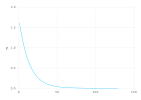

In [15]:
# Plotting your objective when training is one of the most effective ways to understand if something is wrong.
plot(y=[objective(m, xys) for m in models], Geom.line)

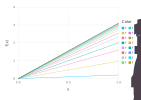

In [16]:
plot([x -> predict(models[j], x) for j in (convert(Int, floor(i)) for i in linspace(1, length(models), 16))], 0, 1)

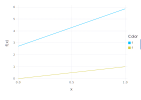

In [17]:
# A slightly less simple linear function we want to learn.
f(x) = π*x + e

plot([f, x -> x], 0, 1)

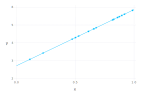

In [18]:
xys = [(x, f(x)) for x in rand(17)]

plot(
    layer(f, 0, 1),
    layer(x=[x for (x, _) in xys], y=[y for (_, y) in xys], Geom.point)
)

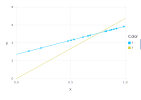

In [19]:
m                  = LinearModel()
objective(m, x, y) = (f(x) - predict(m, x))^2/2

# We are unable to learn this function, why?
for _ in 1:128
    m.w -= μ*∇objective(m, xys)
end
plot(
    layer([f, x -> predict(m, x)], 0, 1),
    layer(x=[x for (x, _) in xys], y=[y for (_, y) in xys], Geom.point)
)

In [20]:
# A more powerful model.
mutable struct LinearModelWithBias
    w::Float64
    b::Float64
end
LinearModelWithBias() = LinearModelWithBias(randn(), 0)
m                     = LinearModelWithBias()
predict(m, x)         = m.w*x + m.b

objective(m, x, y) = (f(x) - predict(m, x))^2/2
objective(m, xys)  = mean(objective(m, x, y) for (x, y) in xys)

# Gradients left as an exercise, replace y′ with mw + b this time and work from there.
∇objective(m, x, y) = [x*((m.w*x + m.b) - y), (m.w*x + m.b) - y]
∇objective(m, xys)  = mean(∇objective(m, x, y) for (x, y) in xys)

models = LinearModelWithBias[deepcopy(m)]        
        
for _ in 1:512
    ∇w, ∇b = ∇objective(m, xys)
    m.w -= μ*∇w
    m.b -= μ*∇b
    push!(models, deepcopy(m))
end

objective(m, xys)

8.488497818763138e-5

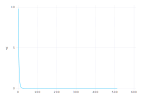

In [21]:
plot(y=[objective(m, xys) for m in models], Geom.line)

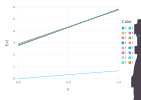

In [22]:
plot([x -> predict(models[j], x) for j in (convert(Int, floor(i)) for i in linspace(1, length(models), 16))], 0, 1)

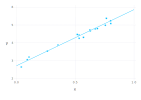

In [23]:
# Samples with Gaussian noise, real-world samples are always noisy.
xys = [(x, f(x) + randn()/7) for x in rand(17)]

plot(
    layer(x=[x for (x, _) in xys], y=[y for (_, y) in xys], Geom.point),
    layer(f, 1, 0)
)

In [24]:
m             = LinearModelWithBias()
predict(m, x) = m.w*x + m.b

objective(m, x, y) = (f(x) - predict(m, x))^2/2
objective(m, xys)  = mean(objective(m, x, y) for (x, y) in xys)

∇objective(m, x, y) = [x*((m.w*x + m.b) - y), (m.w*x + m.b) - y]
∇objective(m, xys)  = mean(∇objective(m, x, y) for (x, y) in xys)

models = LinearModelWithBias[deepcopy(m)]

for _ in 1:512
    ∇w, ∇b = ∇objective(m, xys)
    m.w -= μ*∇w
    m.b -= μ*∇b
    push!(models, deepcopy(m))
end

objective(m, xys)

0.0012595990424544784

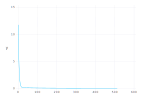

In [25]:
plot(y=[objective(m, xys) for m in models], Geom.line)

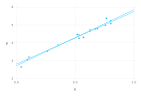

In [26]:
plot(
    layer(x=[x for (x, _) in xys], y=[y for (_, y) in xys], Geom.point),
    layer(x -> predict(m, x), 0, 1),
    layer(f, 0, 1)
)

In [27]:
# http://homepages.inf.ed.ac.uk/imurray2/teaching/oranges_and_lemons/

apples  = Set([1, 3, 4, 5])
oranges = Set([2, 6, 7, 8])
lemons  = Set([9, 10])

# Format: Label, Height, Width, Mass.
fruit_data = readdlm("res/fruit_data.tsv")

# Remove apples and make labels binary.
fruit_data                                 = fruit_data[fruit_data[:, 1] .∈ oranges ∪ lemons, :]
fruit_data[fruit_data[:, 1] .∈ oranges, 1] = 1
fruit_data[fruit_data[:, 1] .∈ lemons, 1]  = 0
# Only work with width and mass to make visualisation easier.
fruit_data = fruit_data[:, [1, 3, 4]]

plot(x=fruit_data[:, 2], y=fruit_data[:, 3], color=fruit_data[:, 1])

LoadError: [91mSystemError: opening file res/fruit_data.tsv: No such file or directory[39m

In [ ]:
# Use a random subset for training, then evaluate generalisation on the rest.
intrain = rand(Bool, size(fruit_data, 1))

train = let
    w = fruit_data[intrain, :]
    [(w[i, 2:end], w[i, 1]) for i in 1:size(w, 1)]
end

plot(x=[x[1] for (x, y) in train], y=[x[2] for (x, _) in train], color=[y for (_, y) in train])

In [ ]:
test = let
    w = fruit_data[.!intrain, :]
    [(w[i, 2:end], w[i, 1]) for i in 1:size(w, 1)]
end

plot(x=[x[1] for (x, _) in test], y=[x[2] for (x, _) in test], color=[y for (_, y) in test])

In [ ]:
# https://en.wikipedia.org/wiki/Logistic_function
σ(x)  = 1/(1 + exp(-x))
σ′(x) = σ(x)*(1 - σ(x))

plot([σ, σ′], -5, 5)

In [ ]:
# Our first classification model.
mutable struct ClassificationModel
    w::Array{Float64}
    b::Float64
end
# Be careful with the initialisation, too large weights hampers learning and may even break it.
ClassificationModel() = ClassificationModel(randn(2)/128, 0)
m                     = ClassificationModel()
predict(m, x)         = σ(m.w'*x + m.b)

println("y", '\t', "y′", '\t', "is orange?")
for (x, y) in train
    println(y, '\t', round(predict(m, x), 3), '\t', predict(m, x) > 0.5)
end

In [ ]:
# Negative Log-Likelihood, maximise the probability of the training data given the model.
objective(m, x, y) = -(y*log(predict(m, x)) + (1 - y)*log(1 - predict(m, x)))
objective(m, xys)  = mean(objective(m, x, y) for (x, y) in xys)
# Precision is more humanly interpretable.
prec(m, xys)       = mean((predict(m, x) > 0.5) == (y == 1) for (x, y) in xys)

(objective(m, train), objective(m, test), prec(m, train), prec(m, test))

In [ ]:
# Warning, this gradient is significantly more difficult to derive -- but it turns out to be beautiful.
∇objective(m, x, y) = [x.*(σ(m.w'*x + m.b) - y), σ(m.w'*x + m.b) - y]
# We can no longer use `mean`, but this is functionally equivalent.
function ∇objective(m, xys)
    ∇ws = zero(m.w)
    ∇bs = zero(m.b)
    for (x, y) in xys
        ∇w, ∇b = ∇objective(m, x, y)
        ∇ws += ∇w
        ∇bs += ∇b
    end
    (∇ws/length(xys), ∇bs/length(xys))
end
 
∇objective(m, train)

In [ ]:
models = ClassificationModel[deepcopy(m)]        

for _ in 1:2048
    ∇w, ∇b  = ∇objective(m, train)
    m.w    -= μ*∇w
    m.b    -= μ*∇b
    push!(models, deepcopy(m))
end

(objective(m, train), objective(m, test), prec(m, train), prec(m, test))

In [ ]:
plot(
layer(y=[objective(m, train) for m in models], Geom.line),
    layer(y=[objective(m, test) for m in models], Geom.line),
)

In [ ]:
println("y", '\t', "y′", '\t', "is orange?")
for (x, y) in train
    println(y, '\t', round(predict(m, x), 3), '\t', predict(m, x) > 0.5)
end

In [ ]:
println("y", '\t', "y′", '\t', "is orange?")
for (x, y) in test
    println(y, '\t', round(predict(m, x), 3), '\t', predict(m, x) > 0.5)
end

In practice, overfitting is usually countered by adding $\lambda |w|$ to the loss function, where $\lambda$ is the regularisation strength.  This hyperparameter is then tuned on a third validation dataset.